# Lyft Data Challenge - Driver Lifetime Value

In this project we are going to be exploring a dataset from the rideshare company Lyft. We have been tasked with trying to determine the average lifetime value of a driver on the platform - that is, once the driver has been onboarded, how long do they typically continue driving with Lyft?

Here are some important questions we'll be answering:

1. Recommend a Driver's Lifetime Value (i.e., the value of a driver to Lyft over the entire projected lifetime of a driver)
2. What are the main factors that affect a driver's lifetime value?
3. What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?
4. Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?
5. What actionable recommendations are there for the business?

Before we tackle any of these we'll explore the data to get familiar with it and do some light feature engineering to aid us in answering the questions. Let's get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
driver_ids = pd.read_csv("data/driver_ids.csv")
ride_ids = pd.read_csv("data/ride_ids.csv")
ride_timestamps = pd.read_csv("data/ride_timestamps.csv")

In [5]:
driver_ids.sample(7)

driver_id  driver_onboard_date
908  f91254f1c1b3112ef3464e477d23c9e8  2016-05-01 00:00:00
293  4e4d07bdf390e67b633e62d3eaabd3dc  2016-04-26 00:00:00
695  b7fbf53260861a5a9022b709abe4d584  2016-04-13 00:00:00
780  d499ea144d46d394e7ece7dc53e9fd41  2016-03-30 00:00:00
793  d967f5296732fa55266b5f1314e7447b  2016-04-09 00:00:00
505  83ae2db3b59285394e07063a7d0d0512  2016-04-19 00:00:00
893  f193cf4d5de76b20688d759ea7c66312  2016-05-03 00:00:00

In [6]:
# pull out some info about the driver data

print("Shape of data:", driver_ids.shape)
print("number of unique driver ids", len(driver_ids["driver_id"].unique()))
print("Minimum date:", driver_ids['driver_onboard_date'].min())
print("Maximum date:", driver_ids['driver_onboard_date'].max())

Shape of data: (937, 2)
number of unique driver ids 937
Minimum date: 2016-03-28 00:00:00
Maximum date: 2016-05-15 00:00:00


In [7]:
ride_ids.sample(7)

driver_id                           ride_id  \
35685   2da7874cc42c3c94f157bd3fd78369b6  1c24eb050af4c612d79e35915accf065   
3775    059ed570673c2d15ca11dd6b3a25513b  9d94708c796dd5c7b942abc2999536e8   
175584  e31ae4a7e10b56e18f3f988fe48acbcb  e415f723e7f8463debc6cd8a8b121b59   
70684   5a880bc9cddbb3845438de87f859c360  2a07625da61f47416e8fbba5fe49a2c2   
148749  ba3a4161ca111c8a2d39a1f1bffd3557  58180cb3eb0cdaf41df2769b99150a80   
25908   23017e4c03d224c89b5e3a0550e1bd9f  1bead1b055bf7c9f202bbe0b872557fe   
121822  98a878a6fe557bf91236e6fc0413faba  5108766ea8a5a335921f2b5d377cf129   

        ride_distance  ride_duration  ride_prime_time  
35685            6197           1027                0  
3775             5424            824                0  
175584           5466            495               25  
70684            5005           1280                0  
148749           3119            943               25  
25908            5242            888                0  
121822           3190           1068                0

In [8]:
print("Shape of data:", ride_ids.shape)
print("Number of unique driver ids:", len(ride_ids["driver_id"].unique()))
print("Number of unique ride ids:", len(ride_ids["ride_id"].unique()))

Shape of data: (193502, 5)
Number of unique driver ids: 937
Number of unique ride ids: 193502


In [9]:
ride_ids.describe()

ride_distance  ride_duration  ride_prime_time
count  193502.000000  193502.000000    193502.000000
mean     6955.218266     858.966099        17.305893
std      8929.444606     571.375818        30.825800
min        -2.000000       2.000000         0.000000
25%      2459.000000     491.000000         0.000000
50%      4015.000000     727.000000         0.000000
75%      7193.000000    1069.000000        25.000000
max    724679.000000   28204.000000       500.000000

One thing to note here is how large of a number each of the max values are. We'll have to determine which metric we want to settle on for each column. For example, the max value in distance is `724679.0`, surely this can't be kilometers or miles so it's most likely in some other distance measure like meters. And the same with ride duration, the max value is `28204.0`. This can't be minutes or hours because that would be an incredibly long car ride, so it must be in seconds.

We are not given much information about the values in the data and are free to make assumptions on our own so we will convert these eventually to the metrics of kilometers and seconds when our analysis calls for it.

In [10]:
ride_timestamps.sample(7)

ride_id           event            timestamp
885599  e9b961d121a1612b4bfa438c01df529d  dropped_off_at  2016-04-25 11:36:25
870294  e5a5029b3b410cb2cdc04eb21a1785bb  dropped_off_at  2016-05-16 07:34:24
808905  d57758876da6de61c5674a9d50e01521    requested_at  2016-04-25 21:23:51
835251  dc88d680e1fe415fa5e9f2870dcd2427     accepted_at  2016-04-11 12:44:26
715013  bcc4e8e108a4a2f5b654da37b5eae521    picked_up_at  2016-04-26 22:22:17
93753   18f17d4e70dfc421c0f4ec1db6a77694    picked_up_at  2016-05-31 00:08:56
805852  d4ac06888bab2a08b83b9772dd67d171      arrived_at  2016-06-02 16:33:46

In [12]:
print("Shape of data:", ride_timestamps.shape)
print("Number of unique driver ids:", len(ride_timestamps["ride_id"].unique()))
ride_timestamps['event'].value_counts()

Shape of data: (970405, 3)
Number of unique driver ids: 194081


requested_at      194081
accepted_at       194081
arrived_at        194081
picked_up_at      194081
dropped_off_at    194081
Name: event, dtype: int64

## Feature Engineering

In the problem description, we're given the following information about what is used in Lyft's rate calculation:

- Base Fare $2.00
- Cost per Mile $1.15
- Cost per Minute $0.22
- Service Fee $1.75
- Minimum Fare $5.00
- Maximum Fare $400.00

Doing a little bit of research, we can find out how the rate is calculated using the information above:

(base fare + cost per mile * ride distance + cost per minute * ride duration) * (1 + (ride prime time/100)) + service fee

Once we calculate that, we should look for any outliers and see if they are above or below the minimum and maximum fares and deal with them appropriately.

In [14]:
# using constant variables for calculation of ride total cost for each ride that occurred in the dataset
BASEFARE = 2.00
COSTPERMILE = 1.15
COSTPERMIN = 0.22
SERVICEFEE  = 1.75
MINFARE = 5.00
MAXFARE = 400.00

# calculating the total cost of each ride
ride_ids["ride_total_cost"] = ((BASEFARE + (COSTPERMIN*(ride_ids["ride_duration"]/60)) + (COSTPERMILE*(ride_ids["ride_distance"]*0.000621))) * (1 + ride_ids["ride_prime_time"]/100)) + SERVICEFEE

# apply an upper and lower bound to ride cost for the min and max fare
ride_ids["ride_total_cost"] = np.where(ride_ids["ride_total_cost"] < MINFARE, MINFARE, ride_ids["ride_total_cost"])
ride_ids["ride_total_cost"] = np.where(ride_ids["ride_total_cost"] > MAXFARE, MAXFARE, ride_ids["ride_total_cost"])

ride_ids.head()

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  ride_total_cost  
0           1811            327               50         8.488488  
1           3362            809                0         9.117306  
2           3282            572                0         8.191174  
3          65283           3338               25        77.826485  
4           4115            823              100        17.662788

## Creating ride features

We're going to pivot the ride_timestamps data so that the type of ride events are now the features, and we'll store that in a variable. Then we can merge that table with the original ride_ids data. We use `pivot()` instead of `pivot_table()` since `pivot()` allows for string types as values, `pivot_table()` only allows for numerical types.

In [16]:
ride_events = ride_timestamps.pivot(index="ride_id", columns="event", values="timestamp")
ride_events.head()

event                                     accepted_at           arrived_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:51  2016-06-13 09:44:31   
00005eae40882760d675da5effb89ae3  2016-05-14 05:23:25  2016-05-14 05:26:17   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:43:14  2016-05-16 15:47:29   
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:29:43  2016-05-11 19:35:11   
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:12:15  2016-04-26 18:16:52   

event                                  dropped_off_at         picked_up_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 10:03:05  2016-06-13 09:44:33   
00005eae40882760d675da5effb89ae3  2016-05-14 05:34:17  2016-05-14 05:26:18   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:54:18  2016-05-16 15:47:32   
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:40:47  2016-05-11 19:35:15   
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:24:14  2016-04-26 18:16:55   

event                                    requested_at  
ride_id                                                
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:19  
00005eae40882760d675da5effb89ae3  2016-05-14 05:23:21  
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:43:09  
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:29:36  
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:11:38

In [17]:
ride_data = pd.merge(ride_ids, ride_events, on="ride_id")
print("Shape of data:", ride_data.shape)
ride_data.head()

Shape of data: (184819, 11)


driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  ride_total_cost  \
0           1811            327               50         8.488488   
1           3362            809                0         9.117306   
2           3282            572                0         8.191174   
3          65283           3338               25        77.826485   
4           4115            823              100        17.662788   

           accepted_at           arrived_at       dropped_off_at  \
0  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   
3  2016-05-19 09:15:33  2016-05-19 09:18:20  2016-05-19 10:13:58   
4  2016-04-20 22:05:32  2016-04-20 22:07:03  2016-04-20 22:20:45   

          picked_up_at         requested_at  
0  2016-04-23 02:16:40  2016-04-23 02:13:50  
1  2016-03-29 19:04:01  2016-03-29 19:00:49  
2  2016-06-21 12:01:35  2016-06-21 11:56:31  
3  2016-05-19 09:18:20  2016-05-19 09:15:29  
4  2016-04-20 22:07:02  2016-04-20 22:05:30

In [18]:
ride_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184819 entries, 0 to 184818
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   driver_id        184819 non-null  object 
 1   ride_id          184819 non-null  object 
 2   ride_distance    184819 non-null  int64  
 3   ride_duration    184819 non-null  int64  
 4   ride_prime_time  184819 non-null  int64  
 5   ride_total_cost  184819 non-null  float64
 6   accepted_at      184819 non-null  object 
 7   arrived_at       184818 non-null  object 
 8   dropped_off_at   184819 non-null  object 
 9   picked_up_at     184819 non-null  object 
 10  requested_at     184819 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 16.9+ MB


Let's now start to convert the values for distance and duration into kilometers and minutes instead of meters and seconds.

In [19]:
# convert ride distance from meters to kilometers
ride_data["ride_distance"] = ride_data["ride_distance"] / 1000
# convert ride duration from seconds to minutes
ride_data["ride_duration"] = ride_data["ride_duration"] / 60

In [22]:
# adding in some more features to the dataset

# how long does it take to accept a ride request
ride_data["ride_accept_response_time"] = (pd.to_datetime(ride_data["accepted_at"]) - pd.to_datetime(ride_data["requested_at"])).astype('timedelta64[s]') / 60

# how long does it take to arrive at the pickup location after the ride is accepted
ride_data["ride_arrival_time"] = (pd.to_datetime(ride_data["arrived_at"]) - pd.to_datetime(ride_data["accepted_at"])).astype('timedelta64[s]') / 60

# how long does the driver wait at the pickup location before the ride starts
ride_data["ride_wait_time"] = (pd.to_datetime(ride_data["picked_up_at"]) - pd.to_datetime(ride_data["arrived_at"])).astype('timedelta64[s]') / 60

# divide the ride distance into 3 categories (short ride, med ride, long ride) dependant on the distance of the ride
ride_data["ride_length"] = np.where(ride_data["ride_distance"] > ride_data["ride_distance"].quantile(0.33), (np.where(ride_data["ride_distance"] < ride_data["ride_distance"].quantile(0.66), "med_ride", "long_ride")), "short_ride")

# divide the ride time to 3 categories (morning ride, evening ride, night ride) dependant on accepted_at time
ride_data["ride_time"] = np.where(pd.to_datetime(ride_data["accepted_at"]).dt.hour > 6, (np.where(pd.to_datetime(ride_data["accepted_at"]).dt.hour <= 15, "morning_ride", (np.where(pd.to_datetime(ride_data["accepted_at"]).dt.hour <= 21, "evening_ride", "night_ride")))), "night_ride")

# convert accepted_at to datetime
ride_data["ride_date"] = pd.to_datetime(ride_data["accepted_at"]).dt.date

ride_data.head()

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  ride_total_cost  \
0          1.811       5.450000               50         8.488488   
1          3.362      13.483333                0         9.117306   
2          3.282       9.533333                0         8.191174   
3         65.283      55.633333               25        77.826485   
4          4.115      13.716667              100        17.662788   

           accepted_at           arrived_at       dropped_off_at  \
0  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   
3  2016-05-19 09:15:33  2016-05-19 09:18:20  2016-05-19 10:13:58   
4  2016-04-20 22:05:32  2016-04-20 22:07:03  2016-04-20 22:20:45   

          picked_up_at         requested_at  ride_accept_response_time  \
0  2016-04-23 02:16:40  2016-04-23 02:13:50                   0.416667   
1  2016-03-29 19:04:01  2016-03-29 19:00:49                   0.050000   
2  2016-06-21 12:01:35  2016-06-21 11:56:31                   0.133333   
3  2016-05-19 09:18:20  2016-05-19 09:15:29                   0.066667   
4  2016-04-20 22:07:02  2016-04-20 22:05:30                   0.033333   

   ride_arrival_time  ride_wait_time ride_length     ride_time   ride_date  
0           2.350000        0.066667  short_ride    night_ride  2016-04-23  
1           3.083333        0.066667    med_ride  evening_ride  2016-03-29  
2           4.883333        0.050000    med_ride  morning_ride  2016-06-21  
3           2.783333        0.000000   long_ride  morning_ride  2016-05-19  
4           1.516667       -0.016667    med_ride    night_ride  2016-04-20

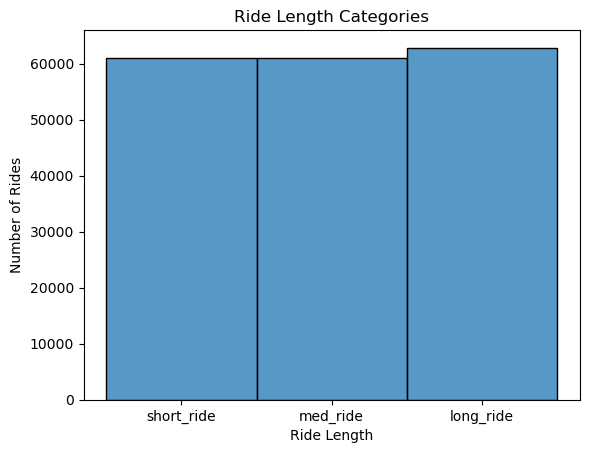

In [29]:
# seaborn histogram of ride length categories
sns.histplot(ride_data["ride_length"], kde=False)
plt.title("Ride Length Categories")
plt.xlabel("Ride Length")
plt.ylabel("Number of Rides")
plt.show();

## Creating Features for Drivers

In [30]:
# calculate the driver per day ride count
driver_perday_ridecount = ride_data.pivot_table(index="driver_id", columns="ride_date", aggfunc="size").fillna(0)
driver_perday_ridecount.head()

ride_date                         2016-03-28  2016-03-29  2016-03-30  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         0.0         6.0         0.0   
007f0389f9c7b03ef97098422f902e62         0.0         1.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9         0.0         0.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0         0.0         0.0   

ride_date                         2016-03-31  2016-04-01  2016-04-02  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         8.0         7.0         5.0   
007f0389f9c7b03ef97098422f902e62         0.0         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9         0.0         0.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0         0.0         0.0   

ride_date                         2016-04-03  2016-04-04  2016-04-05  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         0.0         0.0         7.0   
007f0389f9c7b03ef97098422f902e62         0.0         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         2.0   
0152a2f305e71d26cc964f8d4411add9         0.0         0.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0         0.0         0.0   

ride_date                         2016-04-06  ...  2016-06-17  2016-06-18  \
driver_id                                     ...                           
002be0ffdc997bd5c50703158b7c2491         0.0  ...         1.0         3.0   
007f0389f9c7b03ef97098422f902e62         0.0  ...         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         3.0  ...         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9         0.0  ...         4.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0  ...         8.0         0.0   

ride_date                         2016-06-19  2016-06-20  2016-06-21  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         0.0         2.0         9.0   
007f0389f9c7b03ef97098422f902e62         0.0         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9         0.0         0.0         6.0   
01674381af7edd264113d4e6ed55ecda         0.0         9.0        10.0   

ride_date                         2016-06-22  2016-06-23  2016-06-24  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         3.0         5.0         0.0   
007f0389f9c7b03ef97098422f902e62         2.0         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9        12.0        10.0         5.0   
01674381af7edd264113d4e6ed55ecda        13.0        13.0         9.0   

ride_date                         2016-06-25  2016-06-26  
driver_id                                                 
002be0ffdc997bd5c50703158b7c2491         0.0         0.0  
007f0389f9c7b03ef97098422f902e62         0.0         0.0  
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0  
0152a2f305e71d26cc964f8d4411add9         6.0         3.0  
01674381af7edd264113d4e6ed55ecda         0.0         0.0  

[5 rows x 91 columns]

In [32]:
driver_info = pd.DataFrame()

# calculate the driver total ride count
driver_info["total_ride_count"] = ride_data.pivot_table(index=["driver_id"], aggfunc='size')

# calculate the driver total ride distance
driver_info["total_ride_distance"] = ride_ids.groupby("driver_id")["ride_distance"].sum()

# calculate the driver total ride duration
driver_info["total_ride_duration"] = ride_ids.groupby("driver_id")["ride_duration"].sum()

# calculate driver lifetime value (total revenue)
driver_info["lifetime_value"] = ride_ids.groupby("driver_id")["ride_total_cost"].sum()

# calculate average driver ride per day count
driver_info["perday_ridecount_mean"] = driver_perday_ridecount.mean(axis=1)

# calculate average ride accept response time for every driver
driver_info["accept_response_time_mean"] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_accept_response_time': 'mean'})).iloc[:, 0]

# calculate average ride arrival time for every driver
driver_info["arrival_time_mean"] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_arrival_time': 'mean'})).iloc[:, 0]

# calculate average ride wait time for every driver
driver_info["wait_time_mean"] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_wait_time': 'mean'})).iloc[:, 0]

# count the total # of short/med/long evening rides
driver_info = pd.merge(driver_info, ride_data.pivot_table(index="driver_id", columns='ride_length', aggfunc='size'), on='driver_id')

# count the total # of day/night/evening rides
driver_info = pd.merge(driver_info, ride_data.pivot_table(index="driver_id", columns='ride_time', aggfunc='size'), on='driver_id')

# fill nan values with 0
driver_info = driver_info.fillna(0).reset_index()
driver_info.head()

driver_id  total_ride_count  total_ride_distance  \
0  002be0ffdc997bd5c50703158b7c2491               277              1740287   
1  007f0389f9c7b03ef97098422f902e62                31               117531   
2  011e5c5dfc5c2c92501b8b24d47509bc                34               269653   
3  0152a2f305e71d26cc964f8d4411add9               191              1471239   
4  01674381af7edd264113d4e6ed55ecda               375              3123644   

   total_ride_duration  lifetime_value  perday_ridecount_mean  \
0               221238     3560.056648               3.043956   
1                20497      321.434698               0.340659   
2                29205      482.299206               0.373626   
3               174521     2610.189071               2.098901   
4               357443     5379.644866               4.120879   

   accept_response_time_mean  arrival_time_mean  wait_time_mean  long_ride  \
0                   0.140132           2.883153        0.087184         79   
1                   0.197312           2.952688        0.081183          5   
2                   0.121569           3.720588        0.068137         11   
3                   0.236649           3.908813        0.091885         99   
4                   0.208800           3.608133        0.136800        157   

   med_ride  short_ride  evening_ride  morning_ride  night_ride  
0       103          95         103.0          85.0        89.0  
1        15          11          24.0           6.0         1.0  
2        11          12          24.0           8.0         2.0  
3        51          41          17.0          67.0       107.0  
4       111         107           0.0         350.0        25.0

In [34]:
# calculate how long the driver continues driving with Lyft
onboard_data = pd.merge(ride_data.groupby('driver_id').agg({'accepted_at': max}), driver_ids, on='driver_id')

# calculate the number of days the driver continues driving with Lyft
onboard_data['driver_duration'] = (pd.to_datetime(onboard_data['accepted_at']) - pd.to_datetime(onboard_data['driver_onboard_date'])).astype('timedelta64[D]')
onboard_data = onboard_data[['driver_id', 'driver_duration']]

onboard_data

driver_id  driver_duration
0    002be0ffdc997bd5c50703158b7c2491             86.0
1    007f0389f9c7b03ef97098422f902e62             85.0
2    011e5c5dfc5c2c92501b8b24d47509bc             68.0
3    0152a2f305e71d26cc964f8d4411add9             64.0
4    01674381af7edd264113d4e6ed55ecda             56.0
..                                ...              ...
832  ff419a3476e21e269e340b5f1f05414e             61.0
833  ff714a67ba8c6a108261cd81e3b77f3a             81.0
834  fff482c704d36a1afe8b8978d5486283             34.0
835  fffecccc49436c5389075b13209f0dfa             51.0
836  ffff51a71f2f185ec5e97d59dbcd7a78             53.0

[837 rows x 2 columns]

In [35]:
driver_info = pd.merge(driver_info, onboard_data, on='driver_id', how='inner')
driver_info

driver_id  total_ride_count  total_ride_distance  \
0    002be0ffdc997bd5c50703158b7c2491               277              1740287   
1    007f0389f9c7b03ef97098422f902e62                31               117531   
2    011e5c5dfc5c2c92501b8b24d47509bc                34               269653   
3    0152a2f305e71d26cc964f8d4411add9               191              1471239   
4    01674381af7edd264113d4e6ed55ecda               375              3123644   
..                                ...               ...                  ...   
832  ff419a3476e21e269e340b5f1f05414e               242              2002400   
833  ff714a67ba8c6a108261cd81e3b77f3a               485              2834765   
834  fff482c704d36a1afe8b8978d5486283                35               174394   
835  fffecccc49436c5389075b13209f0dfa               406              2924913   
836  ffff51a71f2f185ec5e97d59dbcd7a78               330              2372018   

     total_ride_duration  lifetime_value  perday_ridecount_mean  \
0                 221238     3560.056648               3.043956   
1                  20497      321.434698               0.340659   
2                  29205      482.299206               0.373626   
3                 174521     2610.189071               2.098901   
4                 357443     5379.644866               4.120879   
..                   ...             ...                    ...   
832               246308     3537.441127               2.659341   
833               442492     6285.948397               5.329670   
834                27693      380.579655               0.384615   
835               353974     6050.600054               4.461538   
836               268641     4579.933147               3.626374   

     accept_response_time_mean  arrival_time_mean  wait_time_mean  long_ride  \
0                     0.140132           2.883153        0.087184         79   
1                     0.197312           2.952688        0.081183          5   
2                     0.121569           3.720588        0.068137         11   
3                     0.236649           3.908813        0.091885         99   
4                     0.208800           3.608133        0.136800        157   
..                         ...                ...             ...        ...   
832                   0.218939           4.651997        0.114738         98   
833                   0.177663           2.976426        0.048144        161   
834                   0.303333           3.835238        0.034762         11   
835                   0.176929           3.572619        0.191051        137   
836                   0.244848           4.702222        0.029293        121   

     med_ride  short_ride  evening_ride  morning_ride  night_ride  \
0         103          95         103.0          85.0        89.0   
1          15          11          24.0           6.0         1.0   
2          11          12          24.0           8.0         2.0   
3          51          41          17.0          67.0       107.0   
4         111         107           0.0         350.0        25.0   
..        ...         ...           ...           ...         ...   
832        56          88          56.0         161.0        25.0   
833       155         169         164.0         308.0        13.0   
834         7          17           1.0          34.0         0.0   
835       141         128         135.0         153.0       118.0   
836       119          90          73.0          49.0       208.0   

     driver_duration  
0               86.0  
1               85.0  
2               68.0  
3               64.0  
4               56.0  
..               ...  
832             61.0  
833             81.0  
834             34.0  
835             51.0  
836             53.0  

[837 rows x 16 columns]

## Exploratory Data Analysis

Now we'll be looking at different aspects of our newly formed and datasets and extracting the necessary info out to answer the questions we've been posed with.

In [36]:
driver_info.describe()

total_ride_count  total_ride_distance  total_ride_duration  \
count        837.000000         8.370000e+02           837.000000   
mean         220.082437         1.528516e+06        189242.789725   
std          178.180347         1.259931e+06        154009.144305   
min            3.000000         9.895000e+03          1712.000000   
25%           44.000000         3.390140e+05         38363.000000   
50%          224.000000         1.451389e+06        189906.000000   
75%          330.000000         2.311846e+06        288097.000000   
max          919.000000         6.628201e+06        779797.000000   

       lifetime_value  perday_ridecount_mean  accept_response_time_mean  \
count      837.000000             837.000000                 837.000000   
mean      2979.103812               2.418488                   0.198516   
std       2416.298144               1.958026                   0.069286   
min         25.687087               0.032967                   0.084074   
25%        618.060833               0.483516                   0.158730   
50%       2958.450547               2.461538                   0.184409   
75%       4475.228280               3.626374                   0.221540   
max      12347.102999              10.098901                   0.687500   

       arrival_time_mean  wait_time_mean   long_ride    med_ride  short_ride  \
count         837.000000      837.000000  837.000000  837.000000  837.000000   
mean            4.417544        0.064720   74.874552   72.569892   72.637993   
std             1.406403        0.127561   60.894880   60.813653   62.422290   
min             1.668056       -1.387415    1.000000    1.000000    1.000000   
25%             3.458333        0.034524   18.000000   14.000000   14.000000   
50%             4.104848        0.059024   71.000000   72.000000   72.000000   
75%             5.042160        0.115833  114.000000  111.000000  112.000000   
max            12.045238        0.491954  335.000000  294.000000  313.000000   

       evening_ride  morning_ride  night_ride  driver_duration  
count    837.000000    837.000000  837.000000       837.000000  
mean      84.874552     85.178017   50.029869        55.075269  
std       81.688592     92.089711   64.935745        21.721934  
min        0.000000      0.000000    0.000000         1.000000  
25%       17.000000     15.000000    5.000000        42.000000  
50%       60.000000     44.000000   22.000000        57.000000  
75%      140.000000    139.000000   74.000000        73.000000  
max      404.000000    515.000000  470.000000        90.000000

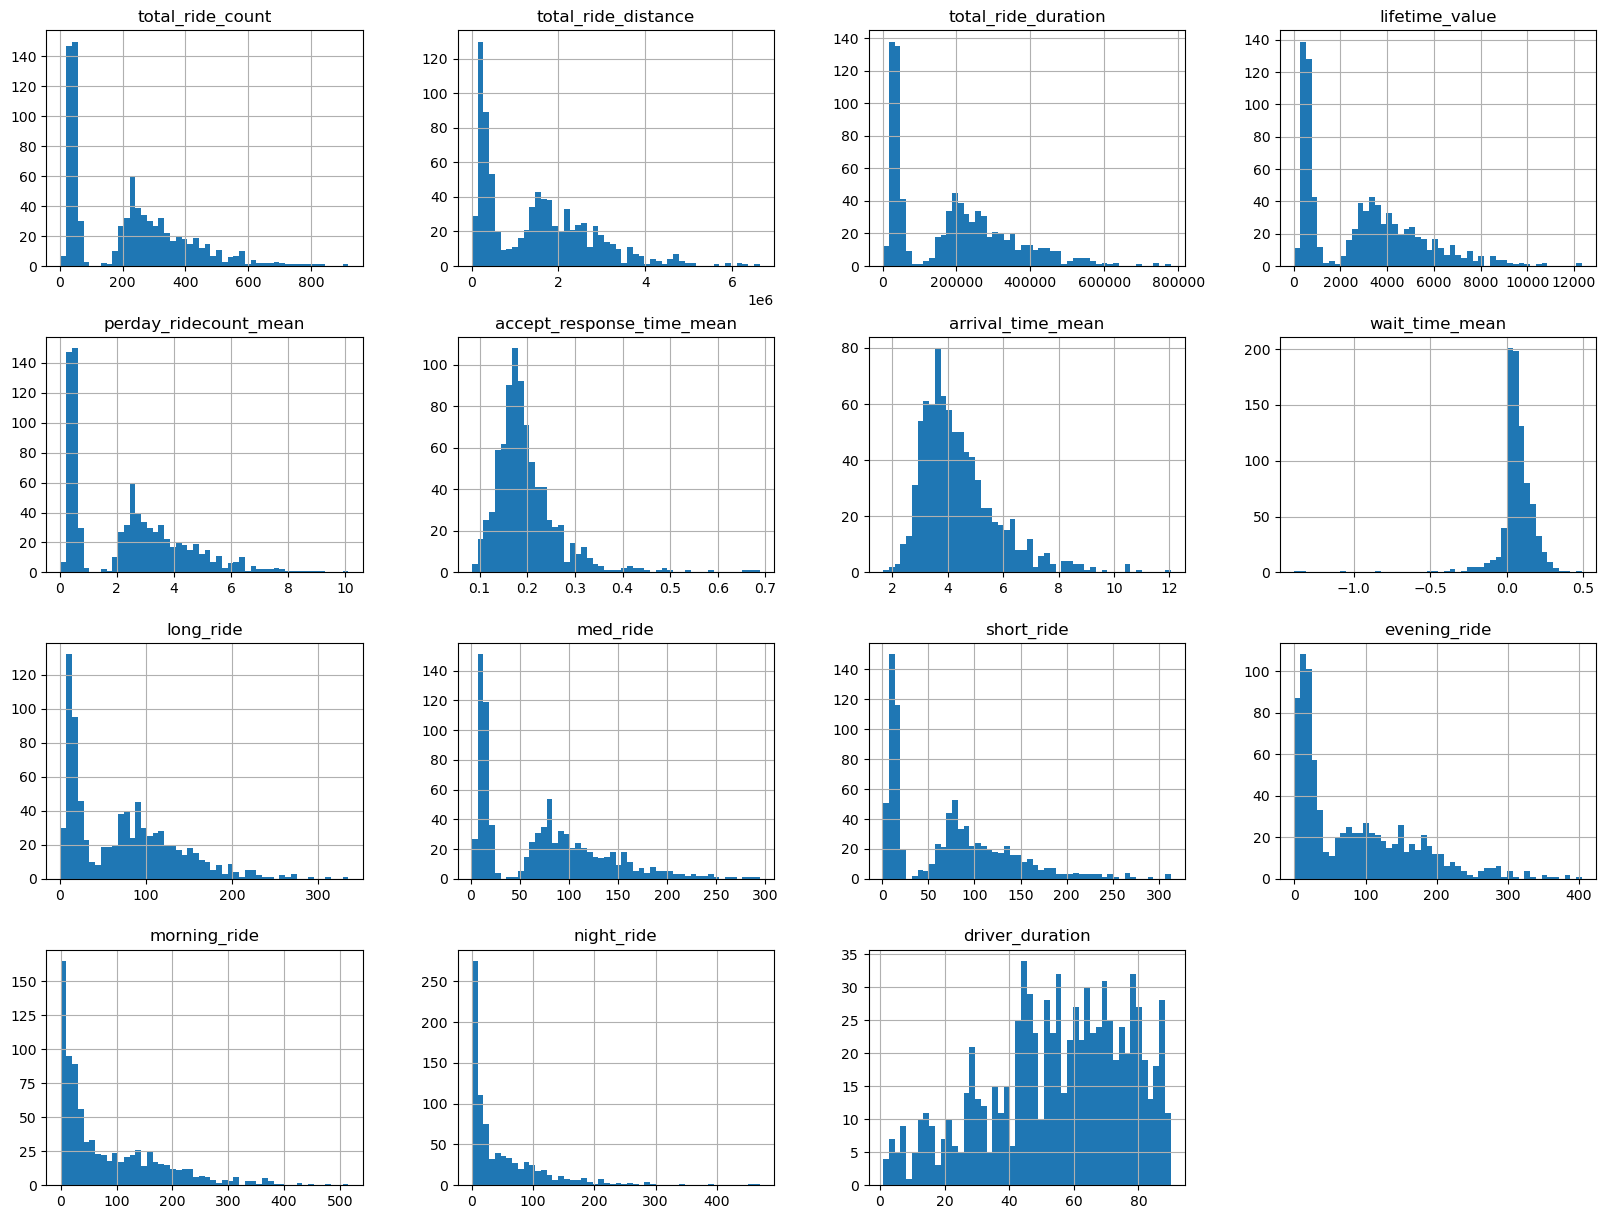

In [38]:
driver_info.hist(bins=50, figsize=(20, 15))
plt.show();

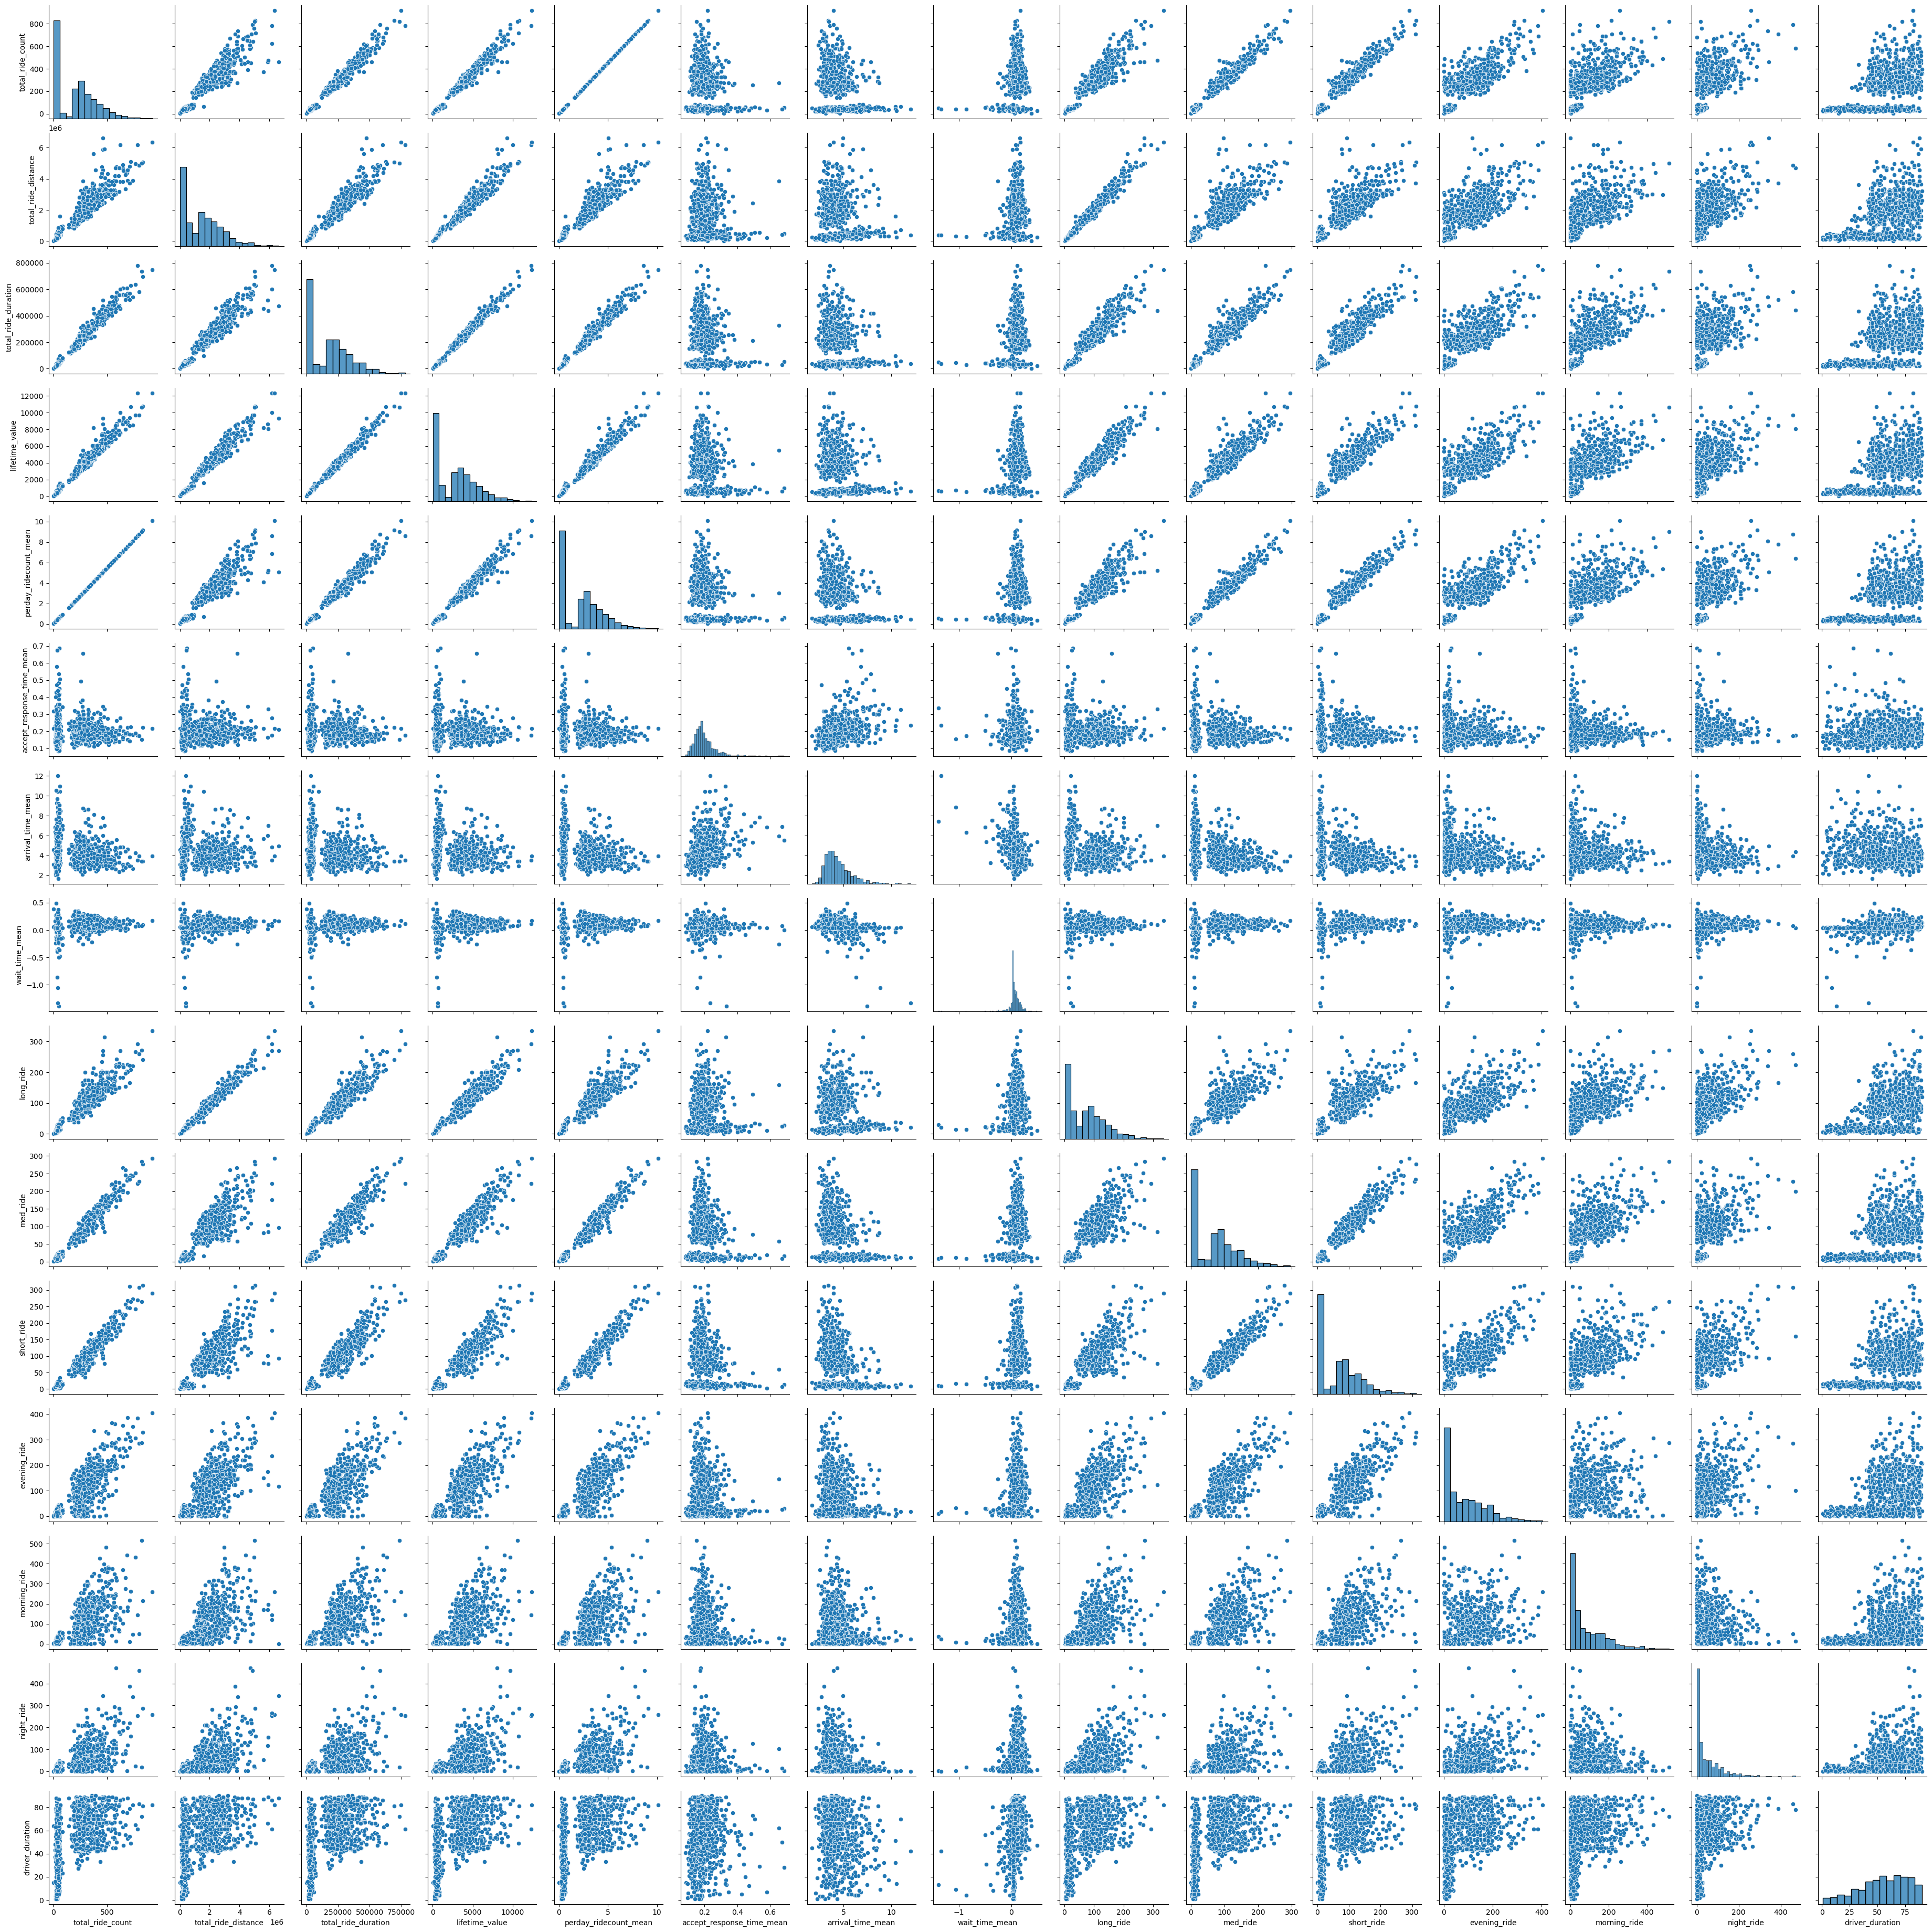

In [39]:
# scatterplots of driver_info data
sns.pairplot(driver_info)

Kinda hurts the eyes a bit doesn't it...

## Main Factors Affectng Driver Lifetime Value

/var/folders/xs/d1td623j4l5_3s9p262jr4yw0000gn/T/ipykernel_66494/2107714749.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(driver_info.corr(), annot=True)


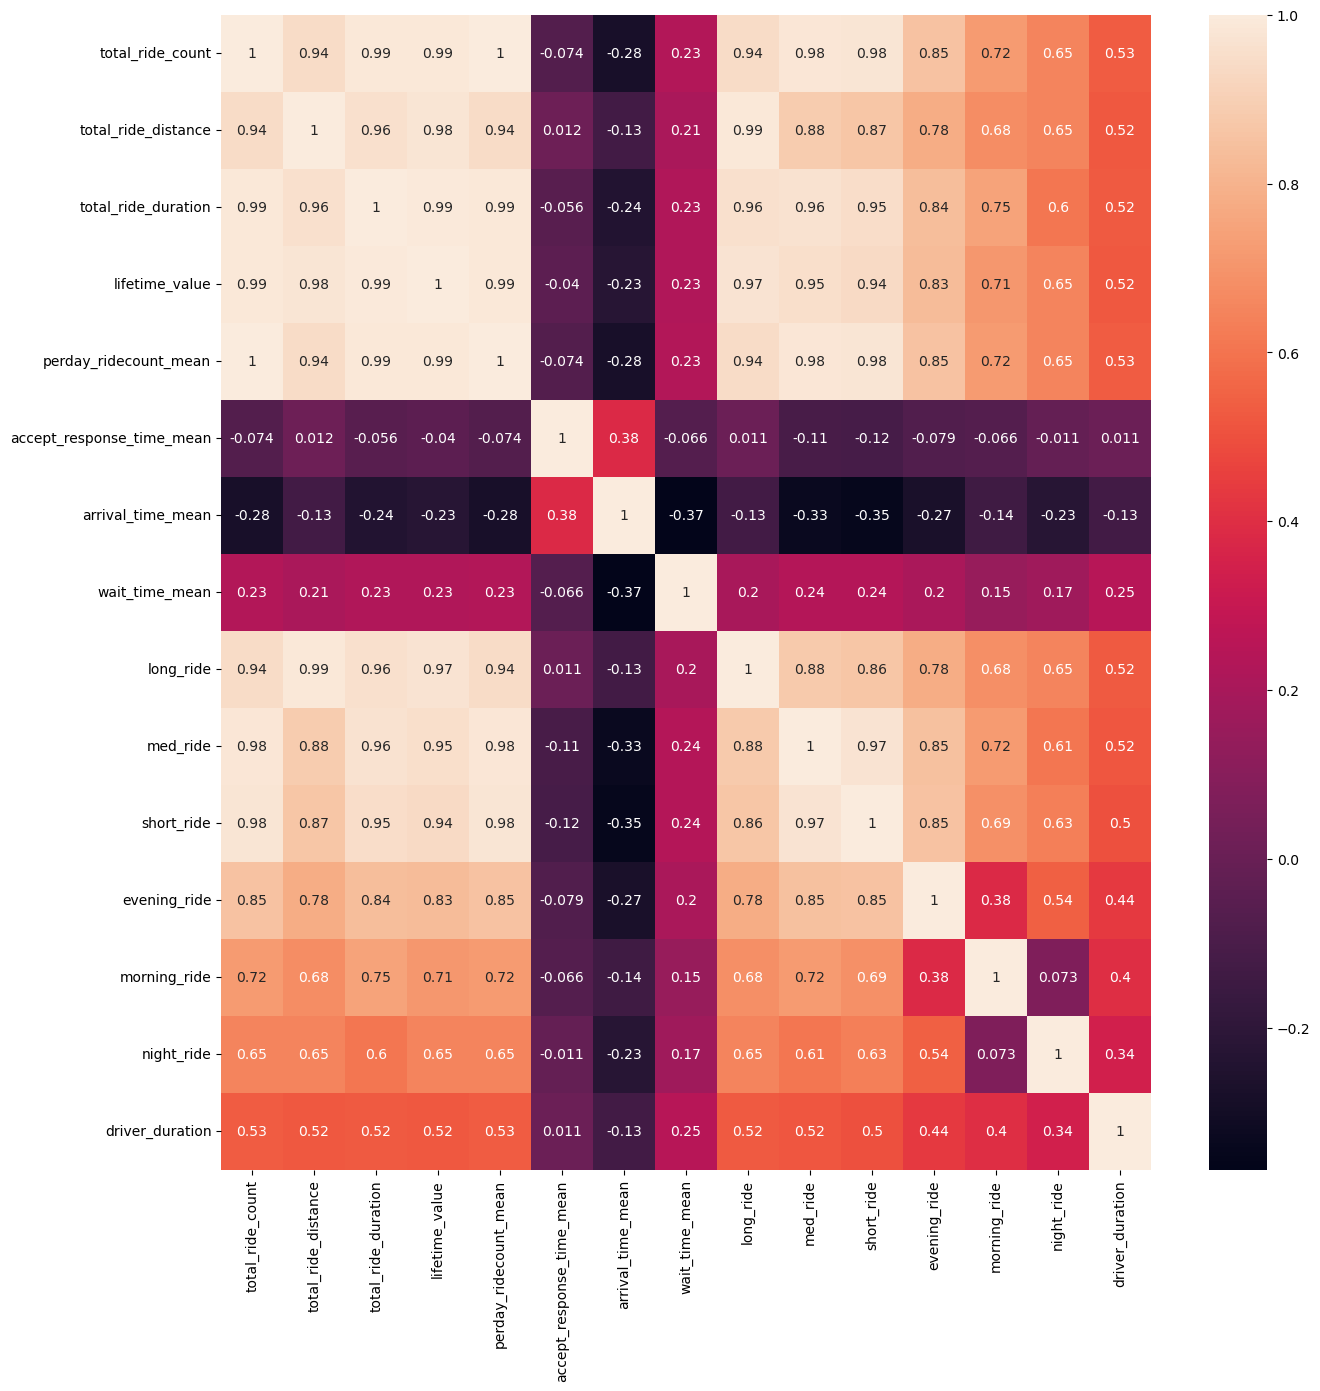

In [46]:
plt.figure(figsize=(15, 15))
sns.heatmap(driver_info.corr(), annot=True)
plt.show();

In [47]:
# correlation with lifetime value as a dataframe and sorted in descending order
pd.DataFrame(driver_info.corr()['lifetime_value']).sort_values(by='lifetime_value', ascending=False).iloc[1:]

/var/folders/xs/d1td623j4l5_3s9p262jr4yw0000gn/T/ipykernel_66494/1322617871.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.DataFrame(driver_info.corr()['lifetime_value']).sort_values(by='lifetime_value', ascending=False).iloc[1:]


lifetime_value
total_ride_duration              0.994194
total_ride_count                 0.987069
perday_ridecount_mean            0.987069
total_ride_distance              0.978453
long_ride                        0.971439
med_ride                         0.954142
short_ride                       0.940301
evening_ride                     0.833416
morning_ride                     0.710687
night_ride                       0.652164
driver_duration                  0.523453
wait_time_mean                   0.226387
accept_response_time_mean       -0.040457
arrival_time_mean               -0.228554

## Average Projected Lifetime Value of a Driver

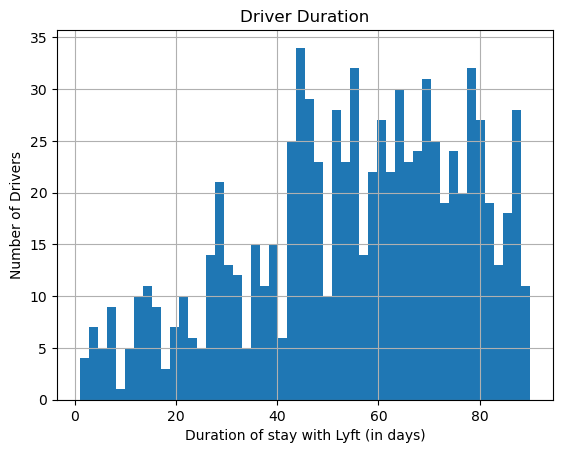

In [48]:
driver_info['driver_duration'].hist(bins=50)
plt.title("Driver Duration")
plt.xlabel("Duration of stay with Lyft (in days)")
plt.ylabel("Number of Drivers")
plt.show();

In [49]:
driver_info['driver_duration'].describe()

count    837.000000
mean      55.075269
std       21.721934
min        1.000000
25%       42.000000
50%       57.000000
75%       73.000000
max       90.000000
Name: driver_duration, dtype: float64

After exploring some of the data, we can say that the average lifetime of a driver with Lyft is approx. 55 days.

## Do All Drivers Act Alike? - Clustering section

Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?

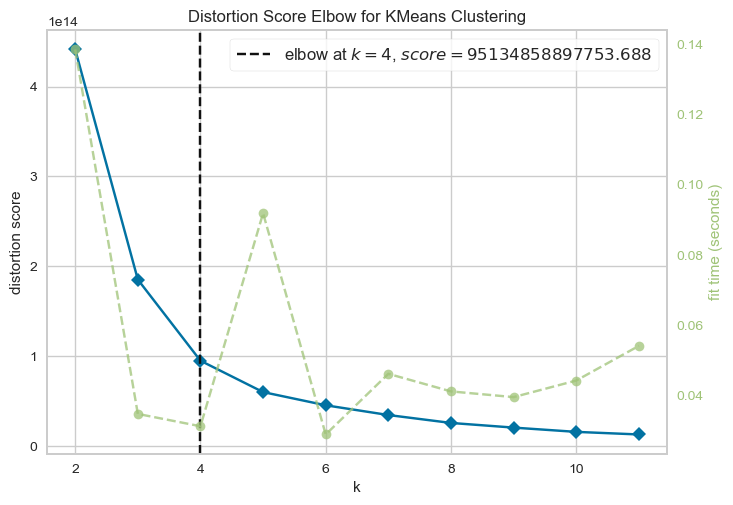

In [50]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings

warnings.filterwarnings("ignore")

# use the KElbowVisualizer to find the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(driver_info.drop(['driver_id'], axis=1))
visualizer.show();

In [52]:
# fit a KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans.fit(driver_info.drop(['driver_id'], axis=1))

KMeans(n_clusters=4, random_state=42)

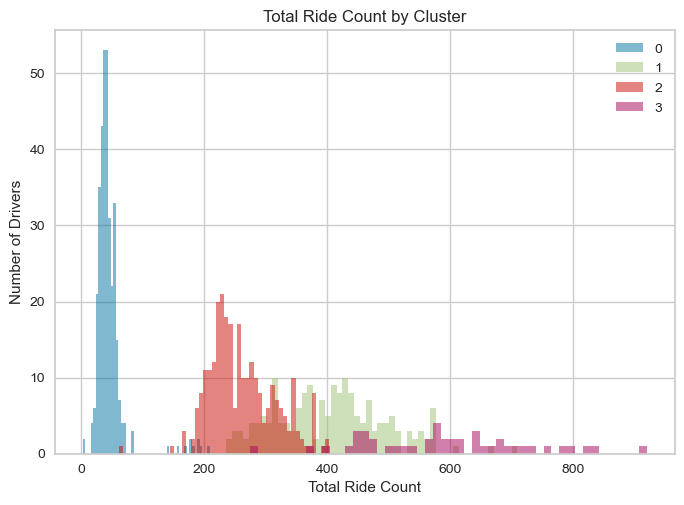

In [53]:
# add the cluster labels to the driver_info dataframe
driver_info['cluster'] = kmeans.labels_

# plot the distribution of the total ride count by cluster
driver_info.groupby('cluster')['total_ride_count'].hist(bins=50, alpha=0.5, legend=True)
plt.title("Total Ride Count by Cluster")
plt.xlabel("Total Ride Count")
plt.ylabel("Number of Drivers")
plt.show();

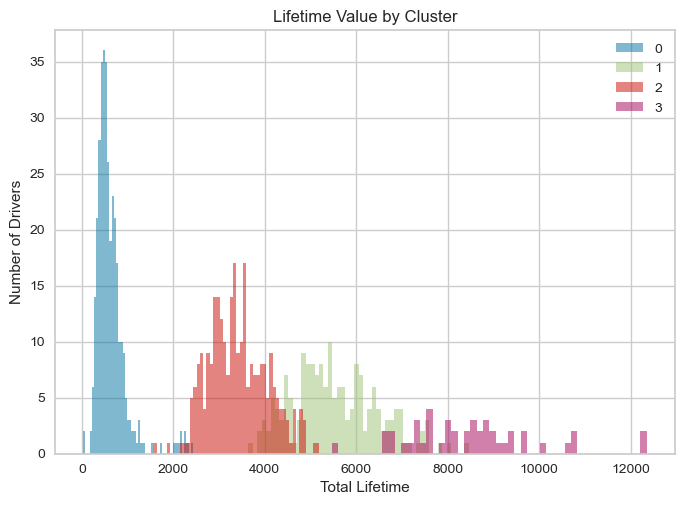

In [54]:
# plot the distributution of total earnings by cluster
driver_info.groupby('cluster')['lifetime_value'].hist(bins=50, alpha=0.5, legend=True)
plt.title("Lifetime Value by Cluster")
plt.xlabel("Total Lifetime")
plt.ylabel("Number of Drivers")
plt.show();

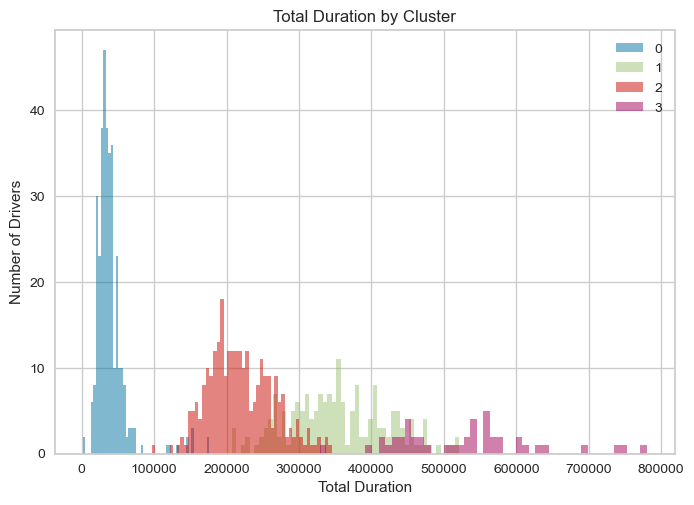

In [56]:
# plot the distributution of total ride duration by cluster
driver_info.groupby('cluster')['total_ride_duration'].hist(bins=50, alpha=0.5, legend=True)
plt.title("Total Duration by Cluster")
plt.xlabel("Total Duration")
plt.ylabel("Number of Drivers")
plt.show();

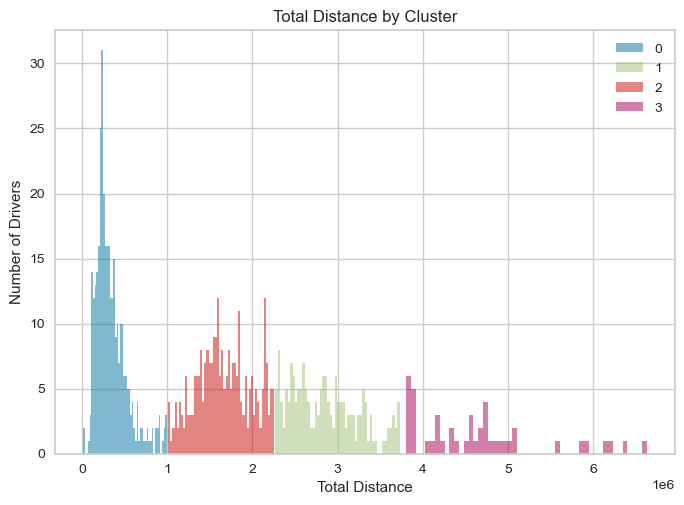

In [57]:
# plot the distributution of total ride distance by cluster
driver_info.groupby('cluster')['total_ride_distance'].hist(bins=50, alpha=0.5, legend=True)
plt.title("Total Distance by Cluster")
plt.xlabel("Total Distance")
plt.ylabel("Number of Drivers")
plt.show();

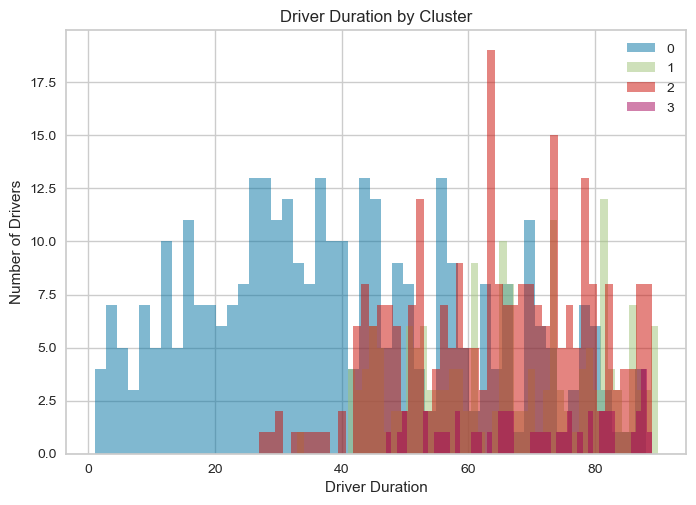

In [58]:
# plot the distribution of driver's duration by cluster
driver_info.groupby('cluster')['driver_duration'].hist(bins=50, alpha=0.5, legend=True)
plt.title("Driver Duration by Cluster")
plt.xlabel("Driver Duration")
plt.ylabel("Number of Drivers")
plt.show();

In [60]:
grouped_df = driver_info.groupby('cluster')['lifetime_value', 'med_ride', 'perday_ridecount_mean', 'total_ride_count', 'short_ride',
                                            'total_ride_duration', 'total_ride_distance', 'long_ride', 'evening_ride', 'night_ride',
                                            'morning_ride', 'driver_duration', 'wait_time_mean'].agg('mean')

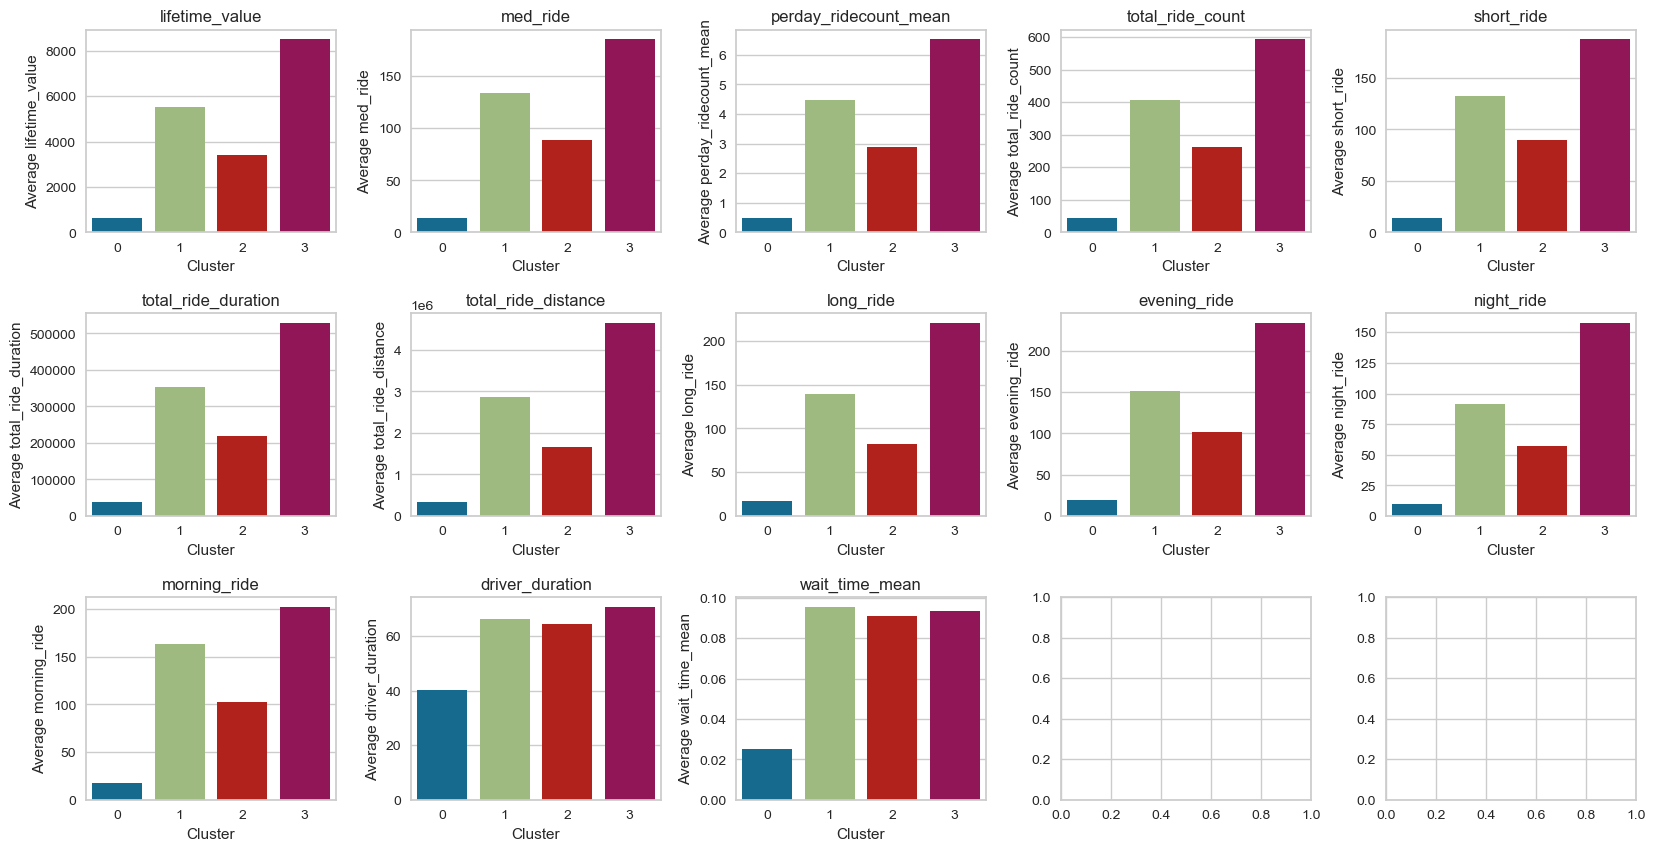

In [64]:
# create subplots for each column in the grouped_df dataframe
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# loop through each column in the grouped_df dataframe and plot it in a subplot
for i, col in enumerate(grouped_df.columns):
    sns.barplot(x=grouped_df.index, y=grouped_df[col], ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(col)
    axes[i//5, i%5].set_xlabel('Cluster')
    axes[i//5, i%5].set_ylabel(f'Average {col}')

plt.show();

After seeing the plots above we can start to define what kind of drivers are in each cluster. They may not be fully representative names but let's just call each cluster respectively as bad drivers, fair drivers, good drivers and excellent drivers:

- Cluster 0 = `Bad drivers`: this cluster contains drivers with low lifetime value, low total ride count, low total ride duration and distance. They may have issues with customer service, low demand for their serives or low fares
- Cluster 2 = `Fair drivers`: this cluster has drivers with a moderate lifetime value, ride count, ride duration and ride distance. They may not have high demand for their services, but they also don't have many major issues impacting their ratings
- Cluster 1 = `Good drivers`: the drivers in this cluster have higher lifetime values than the previous clusters, as well as higher ride count, duration, and distance. They most likely have consistent demand for their services and a good reputation, which could lead to higher earnings
- Cluster 3 = `Excellent drivers`: this cluster has drivers with the highest lifetime value, ride count, distance and duration. These drivers are likely the most in demand and have a great reputation for providing top notch service, leading to high earnings.

## Actionable Recommendations

Here are a few actionable recommendations based on the cluster analysis performed on driver information data:

- Focus on retaining good and excellent drivers: the business should focus on retaining the drivers who belong to the good and excellent clusters as they bring in more revenue and have more frequent rides compared to other driving clusters
- Target improvement of fair drivers: the business should target to improve the performance of fair drivers, to convert them into good or excellent drivers
- Identify and address issues faced by bad drivers: the business should identify and address the issues faced by the bad drivers, such as low earnings, low frequency, and low ride duration, to improve their performance
- Personalized incentives and training: the business can offer personalized incentives and training to drivers based on their performace clusters to further improve their performance
- Use cluster results for dynamic pricing: the cluster results can be used for dynamic pricing, where prices can be adjusted based on the supply and demand of drivers in a particular area
- Monitor performance regularly: the business should regularly monitor the performance of drivers and reassess them based on the clustering results to ensure that they are being properly targeted with the appropriate incentives and support